In [11]:
%matplotlib inline
import matplotlib
import numpy as np
from astropy.io.votable import parse_single_table
import matplotlib.pyplot as plt
import glob, os
import pandas as pd
from astropy.cosmology import WMAP9 as cosmo
import numpy_indexed as npi
import pysynphot as S
from extinction import ccm89, apply
import sfdmap
from astropy.io import fits
from scipy import spatial
from scipy import stats
from scipy.interpolate import interp1d
from scipy import interpolate
from kapteyn import kmpfit
from astropy.modeling.blackbody import blackbody_lambda
from astropy.table import Table
import sys
from PyAstronomy import pyasl
import timeit
from scipy.interpolate import UnivariateSpline
from astropy.cosmology import FlatLambdaCDM

plt.style.use('my')

33.0


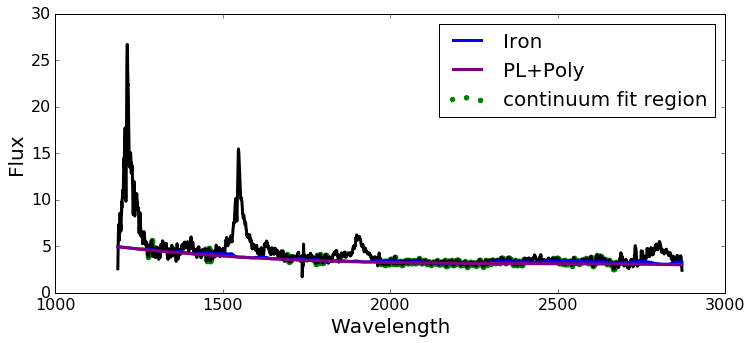

In [16]:
start = timeit.default_timer()

global path
path='/Users/legolason/study/mesfit/'


#---continuum function---------
def Fe_flux_mgii(xval,pp):
    yval = np.zeros_like(xval)
    fe_uv = np.genfromtxt(path+'fe_uv.txt')     #log10(rest wave) flux
    wave_Fe_mgii = 10**fe_uv[:,0]
    flux_Fe_mgii = fe_uv[:,1]*10**15
    Fe_FWHM = pp[1]
    xval_new = xval*(1.0 + pp[2])      
    
    ind = np.where((xval_new > 1200.) & (xval_new < 3500.), True,False)
    if np.sum(ind) > 100:
        if Fe_FWHM < 900.0:
            sig_conv = np.sqrt(910.0**2 - 900.0**2)/2./np.sqrt(2.*np.log(2.)) 
        else:
            sig_conv = np.sqrt(Fe_FWHM**2 - 900.0**2)/2./np.sqrt(2.*np.log(2.))   #in km/s
        #Get sigma in pixel space
        sig_pix = sig_conv/103.6     # 106.3 km/s is the dispersion for the BG92 FeII template
        khalfsz = np.round(4*sig_pix+1,0)
        xx= np.arange(0,khalfsz*2,1) - khalfsz
        kernel = np.exp(-xx**2/(2*sig_pix**2))
        kernel = kernel/np.sum(kernel)
        
        flux_Fe_conv = np.convolve(flux_Fe_mgii, kernel,'same')
        tck = interpolate.splrep(wave_Fe_mgii, flux_Fe_conv) 
        yval[ind] = pp[0]*interpolate.splev(xval_new[ind], tck)
    return yval

def Fe_flux_balmer(xval,pp):
    yval = np.zeros_like(xval)
    fe_op=np.genfromtxt(path+'fe_optical.txt') #log10(rest wave) flux
    wave_Fe_balmer = 10**fe_op[:,0]
    flux_Fe_balmer = fe_op[:,1]*10**15
    ind = np.where((wave_Fe_balmer > 3686.) & (wave_Fe_balmer < 7484.),True,False)
    wave_Fe_balmer = wave_Fe_balmer[ind]
    flux_Fe_balmer = flux_Fe_balmer[ind]
    Fe_FWHM = pp[1]
    xval_new = xval*(1.0 + pp[2])
    ind = np.where((xval_new > 3686.) & (xval_new < 7484.),True,False)
    if np.sum(ind) > 100:
        if Fe_FWHM < 900.0:
            sig_conv = np.sqrt(910.0**2 - 900.0**2)/2./np.sqrt(2.*np.log(2.)) 
        else:
            sig_conv = np.sqrt(Fe_FWHM**2 - 900.0**2)/2./np.sqrt(2.*np.log(2.))  #in km/s
        #Get sigma in pixel space
        sig_pix = sig_conv/106.3    # 106.3 km/s is the dispersion for the BG92 FeII template
        khalfsz = np.round(4*sig_pix+1,0)
        xx= np.arange(0,khalfsz*2,1) - khalfsz
        kernel = np.exp(-xx**2/(2*sig_pix**2))
        kernel = kernel/np.sum(kernel)
        flux_Fe_conv = np.convolve(flux_Fe_balmer, kernel,'same')
        tck = interpolate.splrep(wave_Fe_balmer, flux_Fe_conv) 
        yval[ind] = pp[0]*interpolate.splev(xval_new[ind], tck)
    return yval

def balmer_conti(xval, pp):
    # Balmer continuum from the model of Dietrich+02
    # xval = input wavelength, in units of A
    # pp=[norm, Te, tau_BE] -- in units of [--, K, --]

    lambda_BE = 3646.  # A
    bbflux = blackbody_lambda(xval,pp[1]).value*3.14 # in units of ergs/cm2/s/A
    tau = pp[2]*(xval/lambda_BE)**3
    result = pp[0]*bbflux*(1. - np.exp(-tau))
    ind = np.where(xval > lambda_BE,True,False)
    if ind.any() == True:
        result[ind]=0.
    return result

def f_poly_conti(xval, pp):
    xval2 = xval - 3000.
    yval = 0.*xval2
    for i in range(len(pp)):
        yval = yval + pp[i]*xval2**(i+1)
    return yval

    
def f_conti_all(xval, pp):
    
    # pp[0]: norm_factor for the MgII Fe_template
    # pp[1]: FWHM for the MgII Fe_template
    # pp[2]: small shift of wavelength for the MgII Fe template
    # pp[3:5]: same as pp[0:2] but for the Hbeta/Halpha Fe template
    # pp[6]: norm_factor for continuum f_lambda = (lambda/3000.0)^{-alpha}
    # pp[7]: slope for the power-law continuum
    # pp[8:10]: norm, Te and Tau_e for the Balmer continuum at <3646 A
    # pp[11:*]: polynomial for the continuum
    
    f_Fe_MgII = Fe_flux_mgii(xval, pp[0:3])      # iron flux for MgII line region
    f_Fe_Balmer = Fe_flux_balmer(xval, pp[3:6])  # iron flux for balmer line region
    f_pl = pp[6]*(xval/3000.0)**pp[7]             # power-law continuum
    f_conti_BC = balmer_conti(xval, pp[8:11])    # Balmer continuum
    f_poly = f_poly_conti(xval, pp[11:])        # polynormal conponent for reddened spectra
    

    if Fe_uv_op == True and poly == False and BC == False :
        yval = f_pl + f_Fe_MgII + f_Fe_Balmer 
    if Fe_uv_op == True and poly == True and BC == False :
        yval = f_pl + f_Fe_MgII + f_Fe_Balmer + f_poly
    if Fe_uv_op == True and poly == False and BC == True :
        yval = f_pl + f_Fe_MgII + f_Fe_Balmer + f_poly + f_conti_BC 
    if Fe_uv_op == False and poly == True and BC == False :
        yval = f_pl + f_poly
    if Fe_uv_op == False and poly == False and BC == False :
        yval = f_pl 
    return yval

def residuals(pp, data):

    xval, yval, weight = data

    return (yval - f_conti_all(xval,pp))/weight

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

    


#---------------------------------------------------------------------------
#Main Routine
#---------------------------------------------------------------------------

#input parameters-----------
Fe_uv_op = True
poly = True
BC = False

#-------------------------


window_all = np.array([ [1150., 1170.], [1275., 1290.], [1350., 1360.], [1445., 1465.],\
                        [1690., 1705.], [1770., 1810.], [1970., 2400.], [2480., 2675.],\
                        [2925., 3400.], [3775., 3832.], [4000., 4050.], [4200., 4230.],\
                        [4435., 4640.], [5100., 5535.], [6005., 6035.], [6110., 6250.],\
                        [6800., 7000.], [7160., 7180.], [7500., 7800.], [8050., 8150.] ])



for path1 in zip(glob.glob(path+'test/data/high/*4-0380.fits'),range(len(glob.glob(path+'test/data/high/*4-0380.fits')))):
    #read data
    data=fits.open(path1[0])
    z=data[2].data['z']
    lam=np.asarray(10**data[1].data['loglam'],dtype=np.float64)
    flux=smooth(np.asarray(data[1].data['flux'],dtype=np.float64),nsmooth)
    err=np.asarray(1./np.sqrt(data[1].data['ivar']),dtype=np.float64)
    
    
        
    #all in rest frame
    wave = lam/(1.0+z)
    tmp_all = np.array([np.repeat(False,len(lam))]).flatten()

    for jj in range(len(window_all)):
        tmp = np.where( (wave > window_all[jj,0]) & (wave < window_all[jj,1]),True,False)
        tmp_all = np.any([tmp_all, tmp],axis=0)
        #print tmp_all.shape
        

     

    pp0 = [0., 3000., 0., 0., 3000., 0., 1., -1.5, 0., 15000., 0.5, 0., 0., 0.]
    f = kmpfit.Fitter(residuals = residuals, data = (wave[tmp_all], flux[tmp_all], err[tmp_all]))
    f.parinfo = [{'limits':(0.,10.**10)},{'limits':(1200.,10000.)},{'limits':(-0.01,0.01)},\
                 {'limits':(0.,10.**10)},{'limits':(1200.,10000.)},{'limits':(-0.01,0.01)},\
                 {'limits':(0.,10.**10)},{'limits':(-5.,3.)},\
                 {'limits':(0.,10.**10)},{'limits':(10000.,50000.)},{'limits':(0.1,2.)},\
                 None,None,None]          
    f.fit(params0=pp0)
    #print "Best-fit parameters:        ", f.params
    
stop1 = timeit.default_timer()
print  np.round(stop1-start)



# plot block -----------------------------------
f_fe_mgii_model = Fe_flux_mgii(wave,f.params[0:3])
f_fe_balmer_model = Fe_flux_balmer(wave,f.params[3:6])
f_pl_model = f.params[6]*(wave/3000.0)**f.params[7]
f_bc_model = balmer_conti(wave, f.params[8:11])
f_poly_model = f_poly_conti(wave, f.params[11:])

f_conti_model = f_pl_model + f_fe_mgii_model + f_fe_balmer_model + f_poly_model+ f_bc_model



fig=plt.figure(figsize=(12,5))

plt.plot(wave,flux,'k')
plt.scatter(wave[tmp_all],flux[tmp_all],color='green',marker='o',label = 'continuum fit region')  # plot continuum region
plt.plot(wave,f_conti_model,'b',label='Iron')
plt.plot(wave,f_pl_model+f_poly_conti(wave, f.params[11:]),color='purple',label='PL+Poly')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend(fontsize=20)